# Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import torchvision
import random

In [2]:
from transformers import CLIPProcessor, CLIPModel

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import kagglehub
path_to_clipped_freqnet = kagglehub.model_download('aayushpuri01/clipped-freqnet/PyTorch/default/1')
print(path_to_clipped_freqnet)
os.chdir(path_to_clipped_freqnet)
from clipped_freqnet import freqnet

/kaggle/input/clipped-freqnet/pytorch/default/1


In [5]:
path_to_dataloader = kagglehub.model_download('aayushpuri01/dataloader-pipeline-for-dds/PyTorch/default/2')
print(path_to_dataloader)
os.chdir(path_to_dataloader)
from dataloading_pipeline_fixleakage import DataPipeline

/kaggle/input/dataloader-pipeline-for-dds/pytorch/default/2


In [6]:
os.chdir('/kaggle/working')

# Dataloader Configuration

The DataPipeline function takes the following arguments:

1. ***path_to_drive*** and ***data_dir*** are joined to make the complete relative directory path,
   so just split if you have a complete path
2. ***num_images*** (default value set to 20,000): create a subset of the dataset, i.e. 20,000 images will
   be used for training and validation set
3. ***val_split*** set for the portion of limited dataset to use for validation
4. ***batch_size***
5. ***test_size*** (default set to 3000): creates a separate test set of 3000 images. 

Values can be changed for experimentations. 


In [7]:
pipeline = DataPipeline(path_to_drive='/kaggle/input',
                        data_dir='deepfake-dataset/Deepfake_Dataset',
                        val_split=0.3,
                        batch_size=32,
                        num_images=1000,
                        test_size =100)
train_loader, val_loader, test_loader = pipeline.get_loaders()

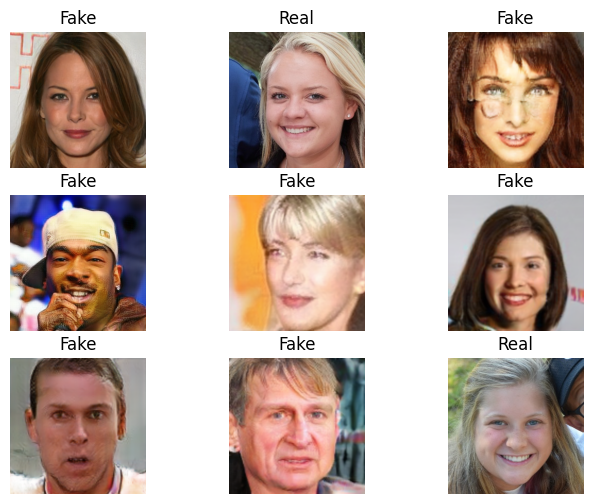

In [8]:
#Visualising some images from the dataloaders, 
#try all the data loaders 
#comment the cell when running the session 

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalized(img_tensor, mean, std):
    img_tensor = img_tensor.clone()  # cloning the tensor to avoid changing it
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize each channel
    return img_tensor

data_iter = iter(val_loader)
images, labels = next(data_iter)
images = torch.stack([denormalized(img, mean, std) for img in images])
images = images.numpy().transpose((0, 2, 3, 1))

fig, axes = plt.subplots(3, 3, figsize = (8, 6))
for i in range(3):
  for j in range(3):
    axes[i][j].imshow(images[i*3+j])
    lbl = labels[i*3+j].item()
    if lbl == 0:
      axes[i][j].set_title("Fake")
    else:
      axes[i][j].set_title("Real")
    axes[i][j].axis('off')
plt.show()

In [7]:
# pipeline = DataPipeline(path_to_drive='/kaggle/input',
#                         data_dir='deepfake-dataset/Deepfake_Dataset',
#                         val_split=0.3,
#                         batch_size=32,
#                         num_images=20000)
# train_loader, val_loader, test_loader = pipeline.get_loaders()

# Model Architecture Config and Init

In [9]:
class HybridDeepfakeDetector(nn.Module):
    def __init__(self, freq_model, clip_model_name="openai/clip-vit-large-patch14", device="cuda"):
        super(HybridDeepfakeDetector, self).__init__()
        self.device = device

        # Load FreqNet
        self.freqnet = freq_model.to(self.device)

        # Load CLIP Model
        self.clip_model = CLIPModel.from_pretrained(clip_model_name).to(self.device)
        self.clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

        # Define Fully Connected Classifier
        self.fc = nn.Linear(512 + 768, 1)  # FreqNet (512) + CLIP (768)

        # ImageNet Denormalization
        imagenet_mean = [0.485, 0.456, 0.406]
        imagenet_std = [0.229, 0.224, 0.225]
        self.denormalize = transforms.Compose([
            transforms.Normalize(mean=[-m / s for m, s in zip(imagenet_mean, imagenet_std)],
                                 std=[1 / s for s in imagenet_std]),
            # transforms.Lambda(lambda x: x.clamp(0, 1))  # Clamp to [0,1]
            transforms.Lambda(HybridDeepfakeDetector.clamp_image)
        ])

    @staticmethod
    def clamp_image(tensor):
        return tensor.clamp(0, 1)
    
    def extract_clip_features(self, images):
        """
        Extract CLIP embeddings from images.
        """
        inputs = self.clip_processor(images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            embeddings = self.clip_model.get_image_features(**inputs)
        return embeddings.to(self.device)

    def forward(self, freq_input, clip_input):
        """
        freq_input: Image tensors normalized with ImageNet stats for FreqNet
        clip_input: Same image tensors (but denormalized) for CLIP
        """
        # Get frequency-based features from FreqNet
        freq_features = self.freqnet(freq_input)

        # Get semantic embeddings from CLIP
        denormalized_images = torch.stack([self.denormalize(image) for image in clip_input])
        clip_features = self.extract_clip_features(denormalized_images)

        # Normalize features and concatenate
        freq_features = F.normalize(freq_features, dim=-1)
        clip_features = F.normalize(clip_features, dim=-1)
        combined_features = torch.cat((freq_features, clip_features), dim=-1)

        # Classifier output
        logits = self.fc(combined_features)
        return logits.squeeze()

In [10]:
#Initialize the models
freqnet_model = freqnet(num_classes=2)  # Assuming `freqnet` function initializes FreqNet
model = HybridDeepfakeDetector(freqnet_model, device=device).to(device)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [11]:
# Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) #set lr = 0.001 optimally? 
criterion = nn.BCEWithLogitsLoss()

# Evaluation on Test Set

In [39]:
from sklearn.metrics import accuracy_score

def evaluate_test_set(model, test_loader, device):
    """
    Evaluate the model on the test set and compute accuracy.
    """

    print('Evaluating the test set...')
    model.eval()# Set model to evaluation mode
    # model.train() #setting the model to train mode to see if the batchNorm are misbehaving

    total = 0
    correct = 0

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing', leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass through the unified model
            outputs = model(images, images)  # Pass the same images for both FreqNet & CLIP

            # Convert logits to binary predictions
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy
    test_acc = correct / total
    print(f'Test Accuracy: {test_acc:.4f}')

    wandb.log({"Test_Accuracy": test_acc})

    return test_acc


# Visualization of embeddings

In [66]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap

In [16]:
# Define a function to reverse ImageNet normalization
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)  # Shape (1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    image = image * std + mean  # Reverse normalization
    return image.clamp(0, 1)  # Ensure values are in [0, 1] range


In [17]:

def analyze_embeddings(model, train_loader, device, num_samples=200, save_images=False):
    """
    Extracts and compares embeddings from FreqNet, CLIP, and Hybrid representation.
    
    Args:
        model: The model containing FreqNet and CLIP components
        train_loader: DataLoader for the dataset
        device: Device to run inference on
        num_samples: Number of samples to analyze (default: 200)
        save_images: Whether to save original images (memory intensive for large num_samples)
        
    Returns:
        Dictionary containing embeddings and metadata
    """
    model.eval()  # Set model to evaluation mode

    sampled_images = []
    freq_embeddings = []
    clip_embeddings = []
    hybrid_embeddings = []
    labels = []
    
    sample_count = 0

    with torch.no_grad():
        for images, batch_labels in train_loader:
            if sample_count >= num_samples:
                break
                
            batch_size = images.size(0)
            # Limit batch to remaining samples needed
            if sample_count + batch_size > num_samples:
                images = images[:num_samples - sample_count]
                batch_labels = batch_labels[:num_samples - sample_count]
                
            images = images.to(device)

            # Forward pass to get embeddings
            freq_features = model.freqnet(images)  # FreqNet embeddings

            denormalized_images = torch.stack([model.denormalize(image) for image in images])
            clip_features = model.extract_clip_features(denormalized_images)
            
            # Normalize and concatenate to get hybrid features
            freq_features_ norm = torch.nn.functional.normalize(freq_features, dim=-1)
            clip_features_norm = torch.nn.functional.normalize(clip_features, dim=-1)
            hybrid_features = torch.cat((freq_features_norm, clip_features_norm), dim=-1)

            # Store embeddings
            if save_images:
                sampled_images.append(images.cpu())  # Store original images
            freq_embeddings.append(freq_features.cpu())
            clip_embeddings.append(clip_features.cpu())
            hybrid_embeddings.append(hybrid_features.cpu())
            labels.append(batch_labels.cpu())
            
            sample_count += images.size(0)
            
            if sample_count % 50 == 0:
                print(f"Processed {sample_count}/{num_samples} samples")

    # Convert lists to numpy arrays
    freq_embeddings = torch.cat(freq_embeddings, dim=0).numpy()
    clip_embeddings = torch.cat(clip_embeddings, dim=0).numpy()
    hybrid_embeddings = torch.cat(hybrid_embeddings, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Compute changes in embeddings
    freq_hybrid_diff = np.linalg.norm(hybrid_embeddings[:, :freq_embeddings.shape[1]] - freq_embeddings, axis=1)
    clip_hybrid_diff = np.linalg.norm(hybrid_embeddings[:, freq_embeddings.shape[1]:] - clip_embeddings, axis=1)

    result = {
        "freq_embeddings": freq_embeddings,
        "clip_embeddings": clip_embeddings,
        "hybrid_embeddings": hybrid_embeddings,
        "labels": labels,
        "freq_hybrid_diff": freq_hybrid_diff,
        "clip_hybrid_diff": clip_hybrid_diff
    }
    
    if save_images:
        result["sampled_images"] = torch.cat(sampled_images, dim=0)
        
    return result


In [ ]:
result_dict = analyze_embeddings(model,
                                train_loader,
                                device,
                                20,
                                save_images=True)

In [31]:
print(result_dict.keys())

dict_keys(['freq_embeddings', 'clip_embeddings', 'hybrid_embeddings', 'labels', 'freq_hybrid_diff', 'clip_hybrid_diff', 'sampled_images'])


In [32]:
images = result_dict['sampled_images']
f_embeddings = result_dict['freq_embeddings']
c_embeddings = result_dict['clip_embeddings']
h_embeddings = result_dict['hybrid_embeddings']
lbls = result_dict['labels']
output_dir = '/kaggle/working'

In [50]:
def visualize_sample_images(images, freq_embeddings, clip_embeddings, 
                          hybrid_embeddings, labels, output_dir):
    """Visualize sample images with their embedding information"""
    num_images = len(images)
    num_images = min(num_images, 8)
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()
    
    for i in range(num_images):
        image = images[i]
        image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = denormalize_image(image)
        
        # Display embedding summary statistics
        freq_mean = np.mean(freq_embeddings[i])
        freq_std = np.std(freq_embeddings[i])
        clip_mean = np.mean(clip_embeddings[i])
        clip_std = np.std(clip_embeddings[i])
        
        label_text = "Fake" if labels[i] == 0 else "Real"
        
        axs[i].imshow(image.numpy())
        axs[i].axis("off")
        axs[i].set_title(f"{label_text}\nFreqNet μ={freq_mean:.3f} σ={freq_std:.3f}\n"
                       f"CLIP μ={clip_mean:.3f} σ={clip_std:.3f}", fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/sample_images.png", dpi=300, bbox_inches='tight')

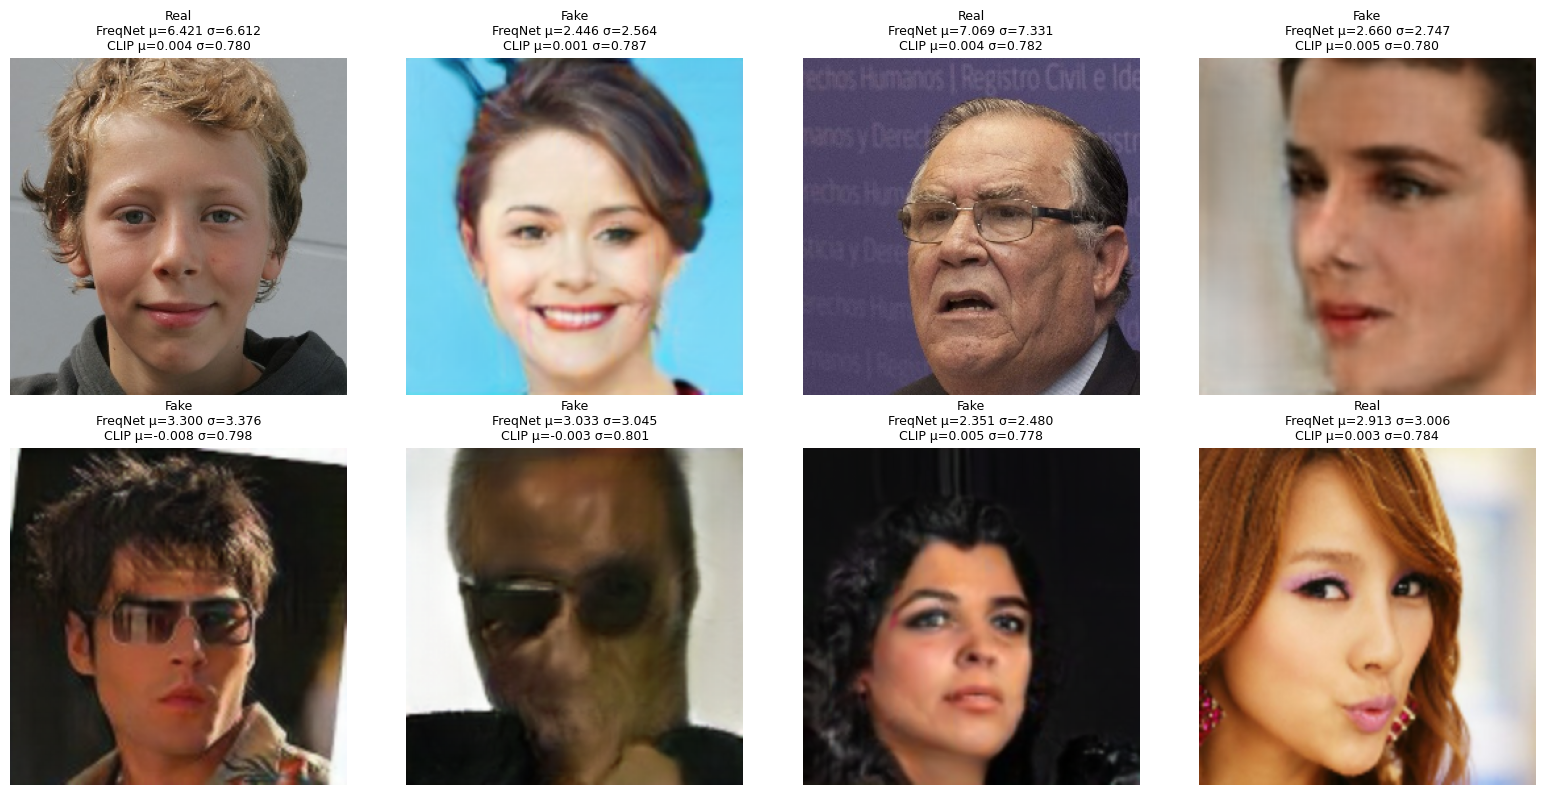

In [52]:
visualize_sample_images(images, f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [53]:
def pca_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir):
    """Generate PCA plots for different embeddings"""
    
    # Set consistent figure size and marker properties
    plt.figure(figsize=(12, 10))
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Process each embedding type
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0], "Blues"),
        ("CLIP", clip_embeddings, axs[1], "Reds"),
        ("Hybrid", hybrid_embeddings, axs[2], "Greens")
    ]
    
    for title, embeddings, ax, cmap in embedding_types:
        # Apply PCA
        pca = PCA(n_components=2, random_state=42)
        reduced = pca.fit_transform(embeddings)
        
        # Calculate explained variance
        explained_var = pca.explained_variance_ratio_
        
        # Create scatter plot with class-based coloring
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], 
                           c=labels, cmap=cmap, alpha=0.7,
                           edgecolors='k', linewidths=0.5)
        
        # Add legend and title
        legend = ax.legend(*scatter.legend_elements(), 
                         loc="upper right", title="Classes")
        ax.add_artist(legend)
        
        ax.set_title(f"{title} PCA\nExplained Var: {sum(explained_var):.2%}")
        ax.set_xlabel(f"PC1 ({explained_var[0]:.2%})")
        ax.set_ylabel(f"PC2 ({explained_var[1]:.2%})")
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pca_visualization.png", dpi=300, bbox_inches='tight')

<Figure size 1200x1000 with 0 Axes>

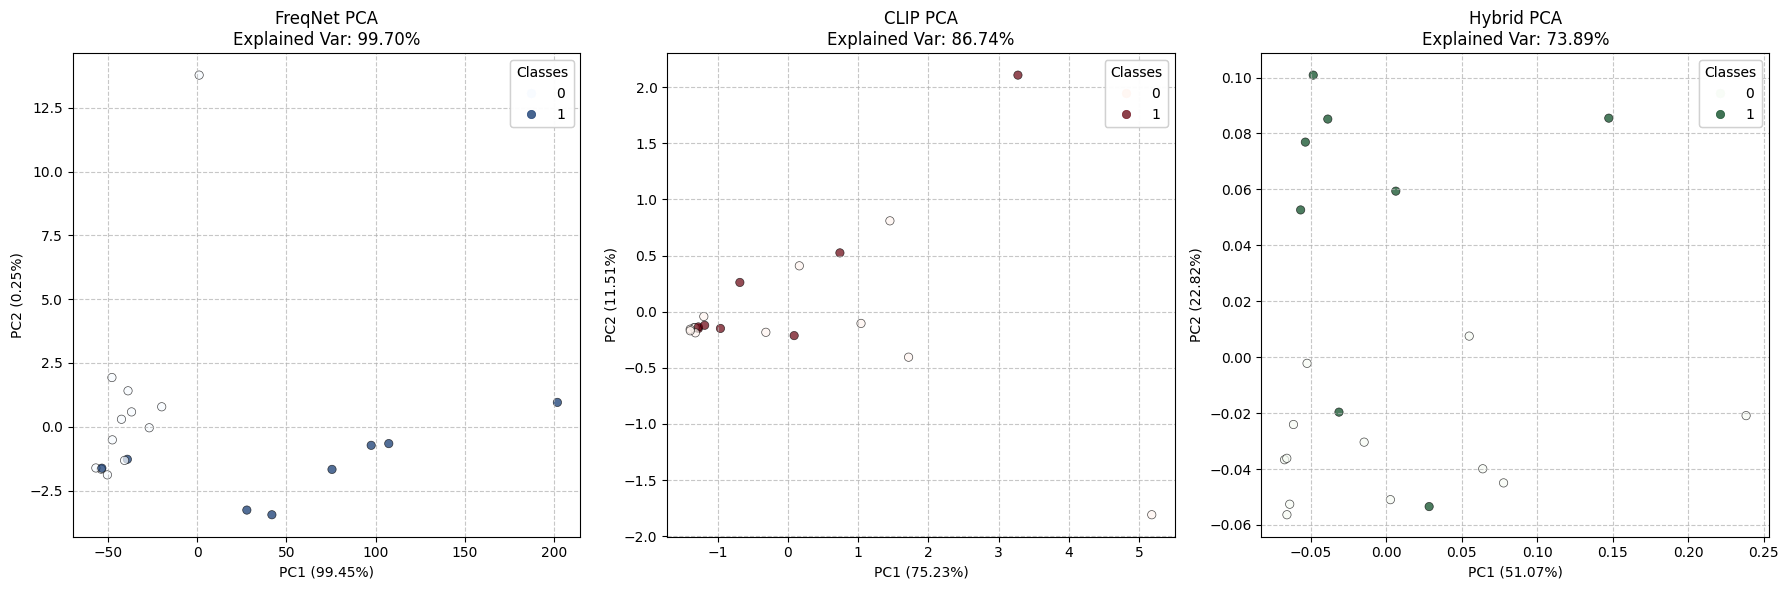

In [55]:
pca_plot(f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [58]:
def tsne_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir):
    """Generate t-SNE plots for different embeddings"""
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Process each embedding type with different perplexity values
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0], "Blues", 5),
        ("CLIP", clip_embeddings, axs[1], "Reds", 5),
        ("Hybrid", hybrid_embeddings, axs[2], "Greens", 7)
    ]
    
    for title, embeddings, ax, cmap, perplexity in embedding_types:
        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        reduced = tsne.fit_transform(embeddings)
        
        # Create scatter plot with class-based coloring
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], 
                           c=labels, cmap=cmap, alpha=0.7,
                           edgecolors='k', linewidths=0.5)
        
        # Add legend and title
        legend = ax.legend(*scatter.legend_elements(), 
                         loc="upper right", title="Classes")
        ax.add_artist(legend)
        
        ax.set_title(f"{title} t-SNE\nPerplexity: {perplexity}")
        ax.set_xlabel("t-SNE1")
        ax.set_ylabel("t-SNE2")
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/tsne_visualization.png", dpi=300, bbox_inches='tight')

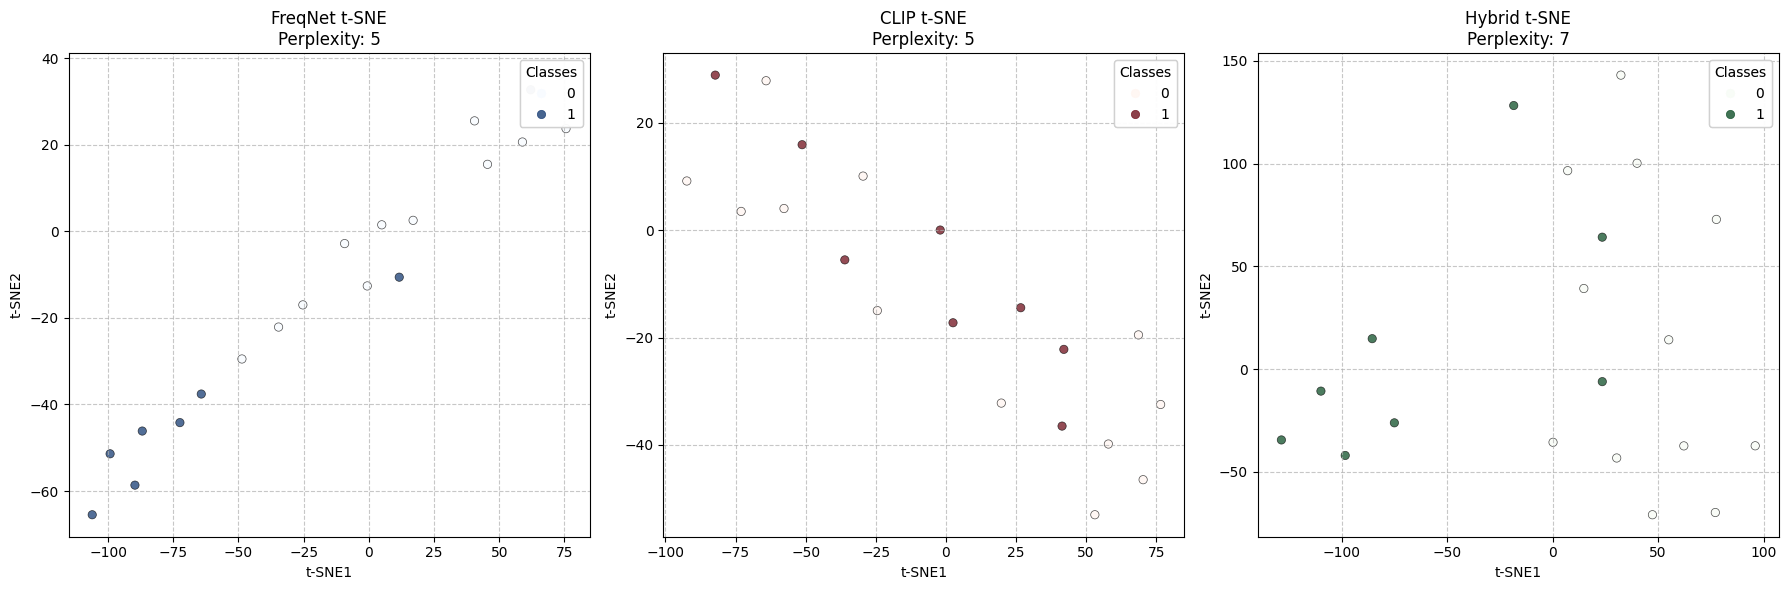

In [59]:
tsne_plot(f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [67]:
def umap_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir):
    """Generate UMAP plots for different embeddings"""
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Process each embedding type
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0], "Blues"),
        ("CLIP", clip_embeddings, axs[1], "Reds"),
        ("Hybrid", hybrid_embeddings, axs[2], "Greens")
    ]
    
    for title, embeddings, ax, cmap in embedding_types:
        # Apply UMAP
        reducer = umap.UMAP(random_state=42)
        reduced = reducer.fit_transform(embeddings)
        
        # Create scatter plot with class-based coloring
        scatter = ax.scatter(reduced[:, 0], reduced[:, 1], 
                           c=labels, cmap=cmap, alpha=0.7,
                           edgecolors='k', linewidths=0.5)
        
        # Add legend and title
        legend = ax.legend(*scatter.legend_elements(), 
                         loc="upper right", title="Classes")
        ax.add_artist(legend)
        
        ax.set_title(f"{title} UMAP")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/umap_visualization.png", dpi=300, bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


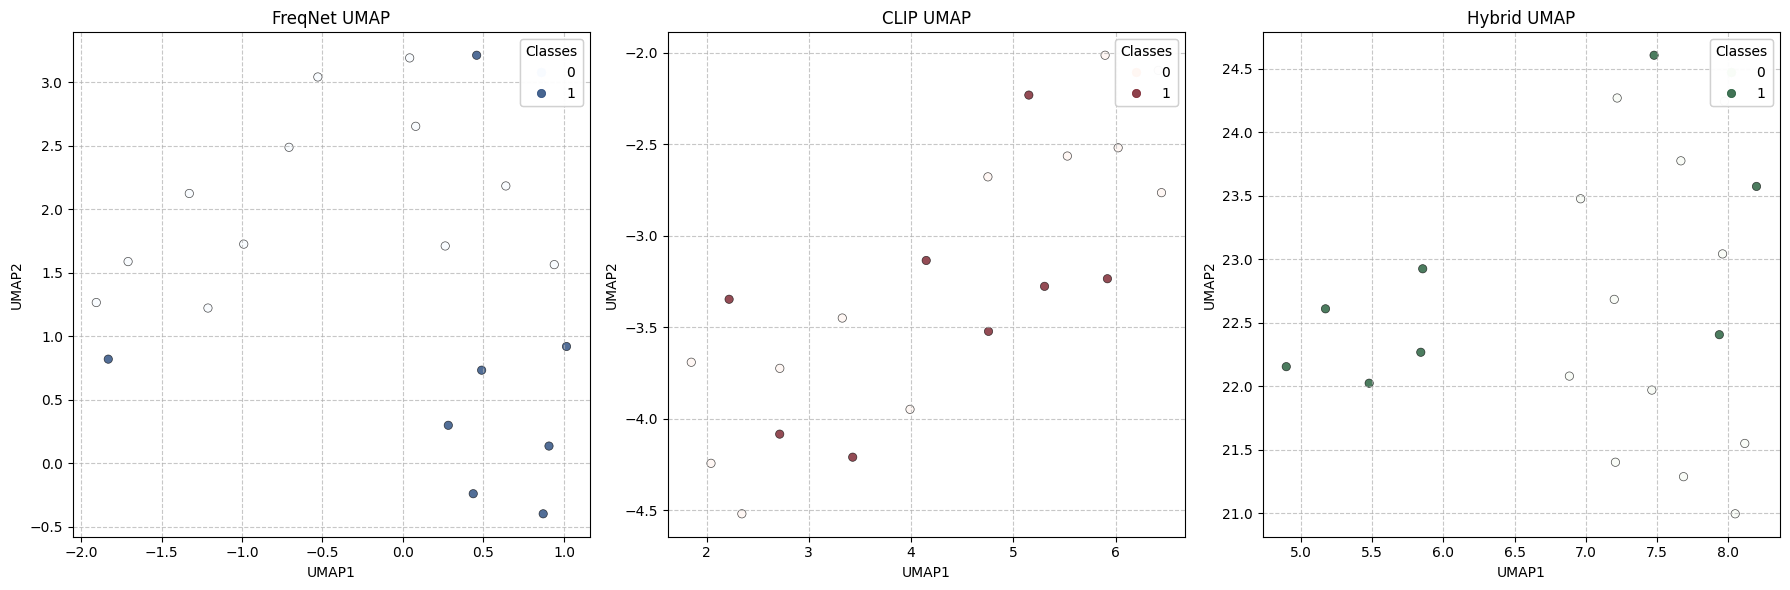

In [68]:
umap_plot(f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [69]:
def visualize_dimensionality_reduction(freq_embeddings, clip_embeddings, 
                                     hybrid_embeddings, labels, output_dir):
    """Visualize embeddings using multiple dimensionality reduction techniques"""
    
    # 1. PCA Visualization
    pca_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir)
    
    # 2. t-SNE Visualization
    tsne_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir)
    
    # 3. UMAP Visualization
    umap_plot(freq_embeddings, clip_embeddings, hybrid_embeddings, labels, output_dir)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1200x1000 with 0 Axes>

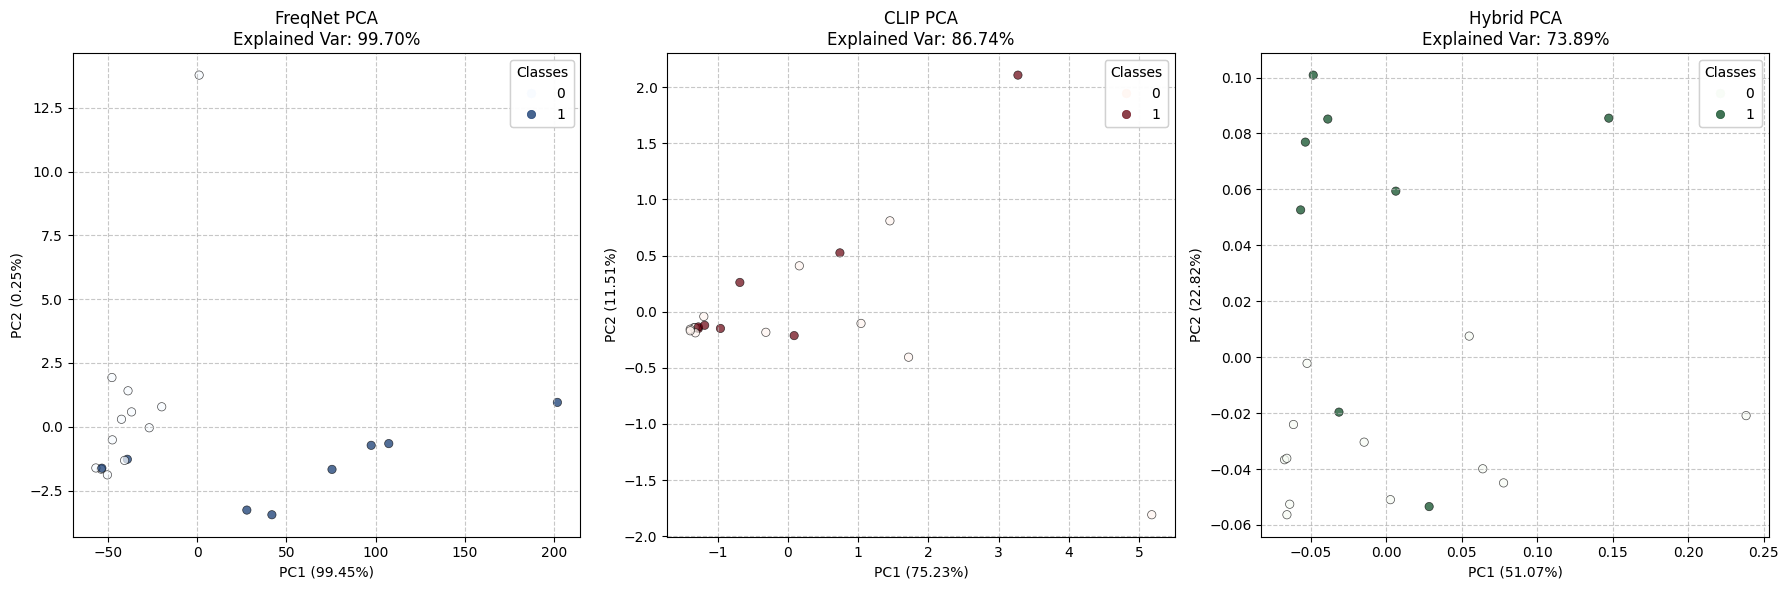

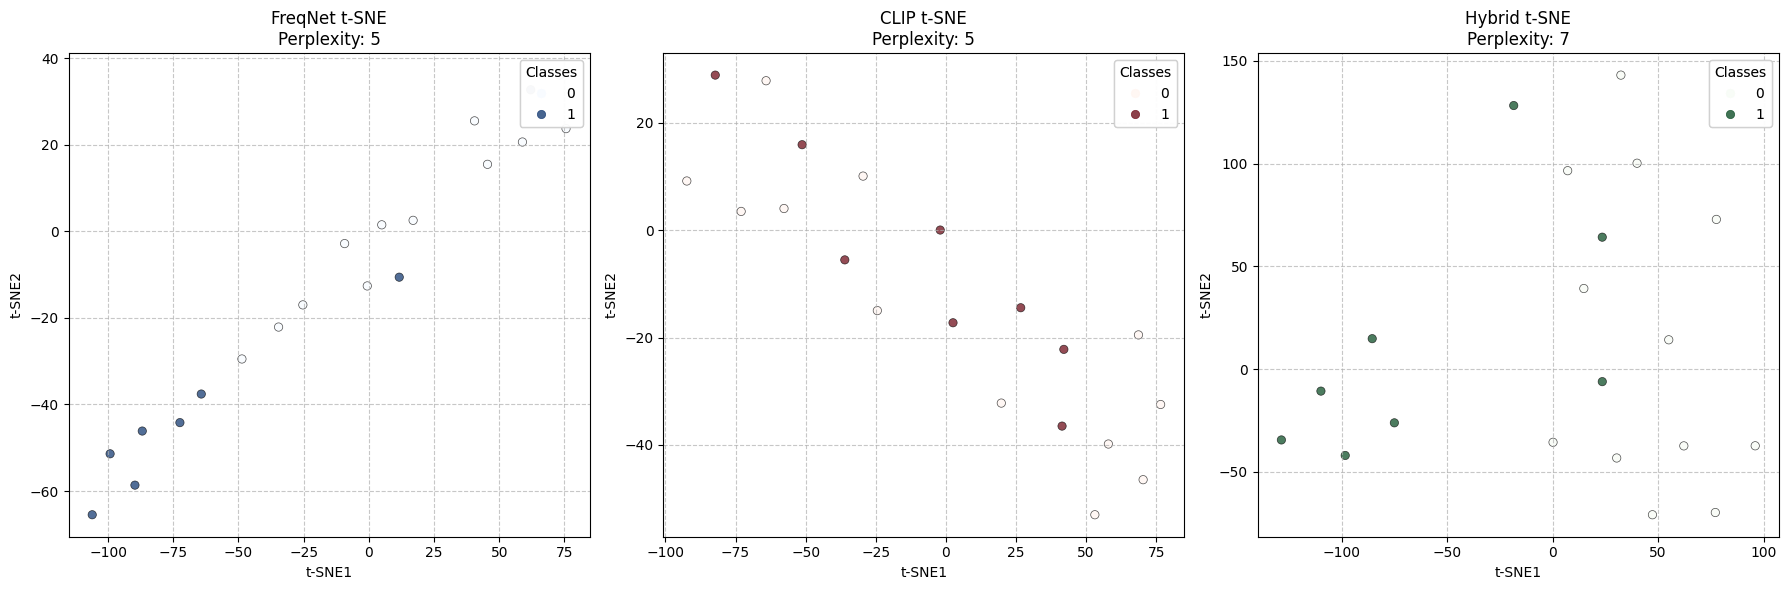

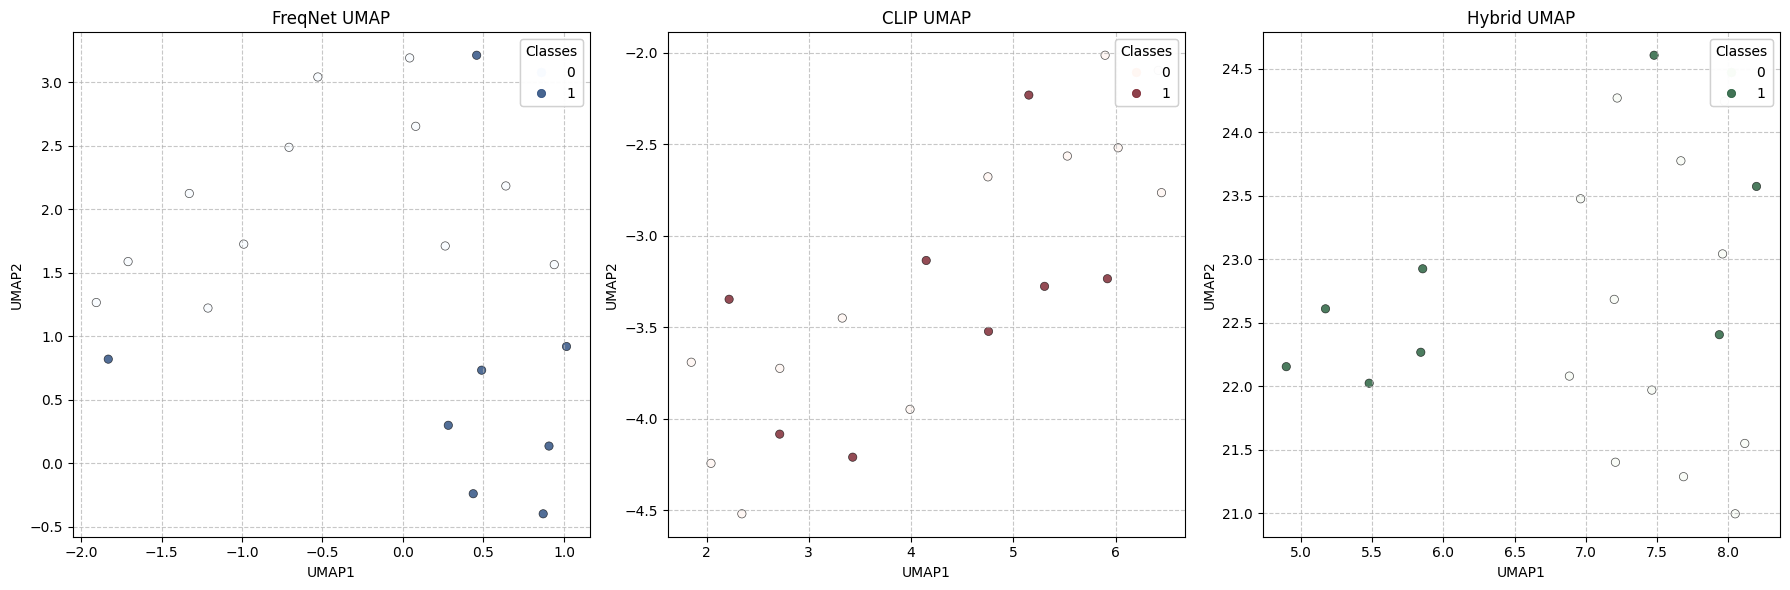

In [70]:
visualize_dimensionality_reduction(f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [71]:
def plot_embedding_magnitudes(freq_embeddings, clip_embeddings, 
                            hybrid_embeddings, labels, output_dir):
    """Plot magnitude distributions of embeddings by class"""
    
    # Calculate embedding magnitudes
    freq_magnitudes = np.linalg.norm(freq_embeddings, axis=1)
    clip_magnitudes = np.linalg.norm(clip_embeddings, axis=1)
    hybrid_magnitudes = np.linalg.norm(hybrid_embeddings, axis=1)
    
    # Create figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # For each embedding type, plot magnitude distributions by class
    embedding_types = [
        ("FreqNet", freq_magnitudes, axs[0]),
        ("CLIP", clip_magnitudes, axs[1]),
        ("Hybrid", hybrid_magnitudes, axs[2])
    ]
    
    for title, magnitudes, ax in embedding_types:
        # Separate by class
        real_magnitudes = magnitudes[labels == 0]
        fake_magnitudes = magnitudes[labels == 1]
        
        # Plot histograms
        ax.hist(real_magnitudes, bins=20, alpha=0.7, label="Real", color="blue")
        ax.hist(fake_magnitudes, bins=20, alpha=0.7, label="Fake", color="red")
        
        # Add statistics annotations
        real_mean, real_std = np.mean(real_magnitudes), np.std(real_magnitudes)
        fake_mean, fake_std = np.mean(fake_magnitudes), np.std(fake_magnitudes)
        
        ax.axvline(real_mean, color="blue", linestyle="--", 
                 label=f"Real μ={real_mean:.2f}")
        ax.axvline(fake_mean, color="red", linestyle="--", 
                 label=f"Fake μ={fake_mean:.2f}")
        
        # Calculate separation metrics
        separation = abs(real_mean - fake_mean) / ((real_std + fake_std) / 2)
        
        # Add title and labels
        ax.set_title(f"{title} Magnitude Distribution\nClass Separation: {separation:.2f}")
        ax.set_xlabel("Embedding Magnitude")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/embedding_magnitudes.png", dpi=300, bbox_inches='tight')

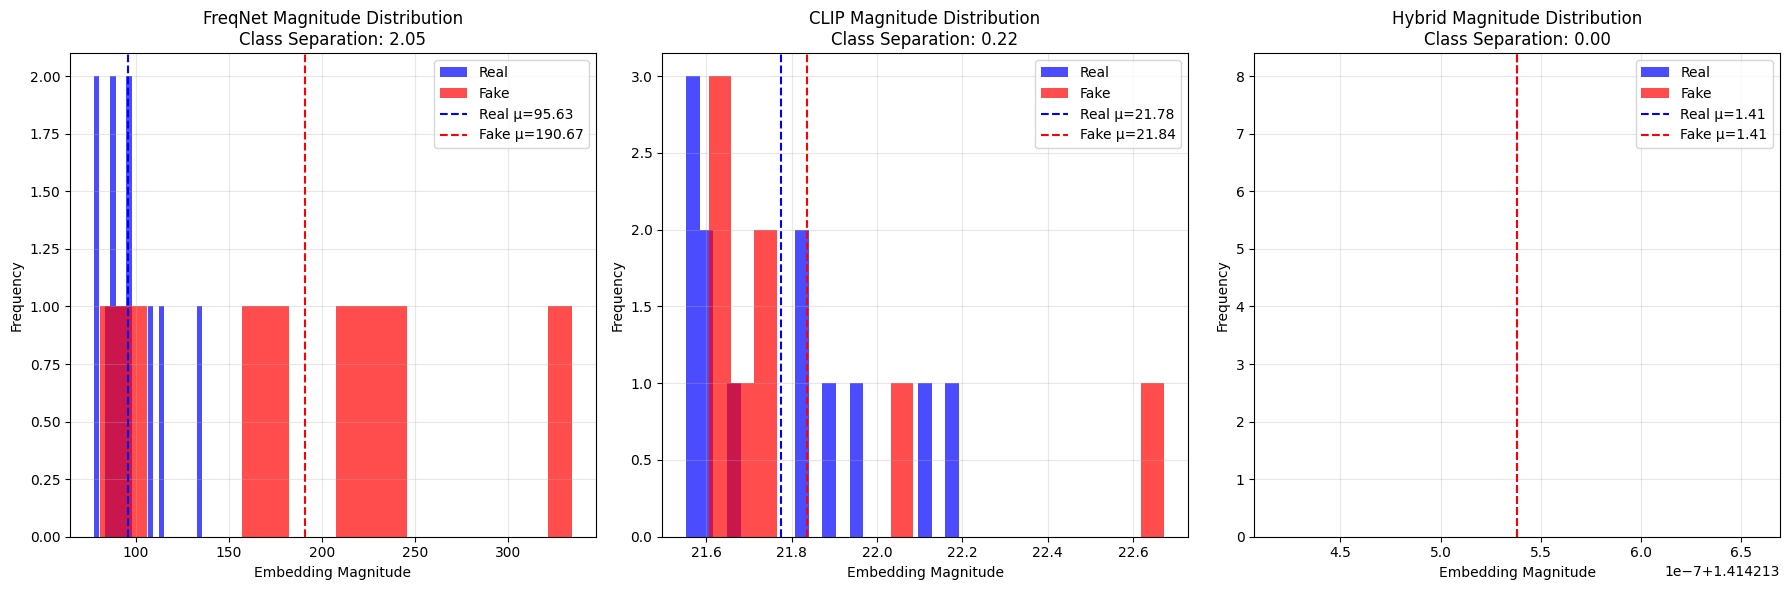

In [72]:
plot_embedding_magnitudes(f_embeddings, c_embeddings, h_embeddings, lbls, output_dir)

In [ ]:

def plot_feature_activations(freq_embeddings, clip_embeddings, 
                           hybrid_embeddings, labels, output_dir):
    """Plot top principal component feature activations by class"""
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0]),
        ("CLIP", clip_embeddings, axs[1]),
        ("Hybrid", hybrid_embeddings, axs[2])
    ]
    
    for title, embeddings, ax in embedding_types:
        # Apply PCA to get components
        pca = PCA(n_components=3, random_state=42)
        pca.fit(embeddings)
        
        # Get top component activations
        top_components = pca.transform(embeddings)[:, :3]
        
        # Separate by class
        real_activations = top_components[labels == 0]
        fake_activations = top_components[labels == 1]
        
        # Create box plots
        positions = np.array([1, 2, 3])
        width = 0.35
        
        real_box = ax.boxplot(real_activations, positions=positions-width/2, 
                            widths=width, patch_artist=True,
                            boxprops=dict(facecolor="lightblue"))
        
        fake_box = ax.boxplot(fake_activations, positions=positions+width/2, 
                           widths=width, patch_artist=True,
                           boxprops=dict(facecolor="lightcoral"))
        
        # Add title and labels
        ax.set_title(f"{title} Top 3 PCA Components\nExplained Var: {sum(pca.explained_variance_ratio_):.2%}")
        ax.set_xlabel("Principal Component")
        ax.set_ylabel("Activation")
        ax.set_xticks(positions)
        ax.set_xticklabels([f"PC{i+1}" for i in range(3)])
        ax.legend([real_box["boxes"][0], fake_box["boxes"][0]], ["Real", "Fake"])
        ax.grid(True, axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_activations.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def plot_cosine_similarities(freq_embeddings, clip_embeddings, 
                           hybrid_embeddings, labels, output_dir):
    """Plot cosine similarity distributions within and between classes"""
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0]),
        ("CLIP", clip_embeddings, axs[1]),
        ("Hybrid", hybrid_embeddings, axs[2])
    ]
    
    for title, embeddings, ax in embedding_types:
        # Get embeddings by class
        real_embeddings = embeddings[labels == 0]
        fake_embeddings = embeddings[labels == 1]
        
        # Calculate pairwise similarities (sample for efficiency if large)
        max_samples = min(100, len(real_embeddings), len(fake_embeddings))
        
        if len(real_embeddings) > max_samples:
            indices = np.random.choice(len(real_embeddings), max_samples, replace=False)
            real_sample = real_embeddings[indices]
        else:
            real_sample = real_embeddings
            
        if len(fake_embeddings) > max_samples:
            indices = np.random.choice(len(fake_embeddings), max_samples, replace=False)
            fake_sample = fake_embeddings[indices]
        else:
            fake_sample = fake_embeddings
        
        # Calculate similarities
        real_real_sim = []
        fake_fake_sim = []
        real_fake_sim = []
        
        # Within real class
        for i in range(len(real_sample)):
            for j in range(i+1, len(real_sample)):
                sim = np.dot(real_sample[i], real_sample[j]) / (
                    np.linalg.norm(real_sample[i]) * np.linalg.norm(real_sample[j]))
                real_real_sim.append(sim)
        
        # Within fake class
        for i in range(len(fake_sample)):
            for j in range(i+1, len(fake_sample)):
                sim = np.dot(fake_sample[i], fake_sample[j]) / (
                    np.linalg.norm(fake_sample[i]) * np.linalg.norm(fake_sample[j]))
                fake_fake_sim.append(sim)
                
        # Between classes
        for i in range(len(real_sample)):
            for j in range(len(fake_sample)):
                sim = np.dot(real_sample[i], fake_sample[j]) / (
                    np.linalg.norm(real_sample[i]) * np.linalg.norm(fake_sample[j]))
                real_fake_sim.append(sim)
        
        # Plot distributions
        ax.hist(real_real_sim, bins=20, alpha=0.7, label="Real-Real", color="blue")
        ax.hist(fake_fake_sim, bins=20, alpha=0.7, label="Fake-Fake", color="red")
        ax.hist(real_fake_sim, bins=20, alpha=0.7, label="Real-Fake", color="purple")
        
        # Add statistics
        rr_mean = np.mean(real_real_sim)
        ff_mean = np.mean(fake_fake_sim)
        rf_mean = np.mean(real_fake_sim)
        
        ax.axvline(rr_mean, color="blue", linestyle="--")
        ax.axvline(ff_mean, color="red", linestyle="--")
        ax.axvline(rf_mean, color="purple", linestyle="--")
        
        # Add title and labels
        ax.set_title(f"{title} Cosine Similarity\nR-R:{rr_mean:.2f} F-F:{ff_mean:.2f} R-F:{rf_mean:.2f}")
        ax.set_xlabel("Cosine Similarity")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/cosine_similarities.png", dpi=300, bbox_inches='tight')
    plt.close()


In [ ]:
def visualize_embedding_stats(freq_embeddings, clip_embeddings, 
                            hybrid_embeddings, labels, output_dir):
    """Visualize embedding distribution statistics"""
    
    # 1. Embedding magnitude distribution by class
    plot_embedding_magnitudes(freq_embeddings, clip_embeddings, 
                            hybrid_embeddings, labels, output_dir)
    
    # 2. Cosine similarity distribution within and between classes
    plot_cosine_similarities(freq_embeddings, clip_embeddings, 
                           hybrid_embeddings, labels, output_dir)
    
    # 3. Feature activation distributions for top principal components
    plot_feature_activations(freq_embeddings, clip_embeddings, 
                           hybrid_embeddings, labels, output_dir)

In [ ]:

def analyze_class_separability(freq_embeddings, clip_embeddings, 
                             hybrid_embeddings, labels, output_dir):
    """Analyze class separability metrics for different embedding types"""
    
    # 1. Silhouette scores across embedding types
    plot_silhouette_scores(freq_embeddings, clip_embeddings, 
                         hybrid_embeddings, labels, output_dir)
    
    # 2. Nearest neighbor analysis (intra-class vs inter-class distances)
    plot_nearest_neighbor_analysis(freq_embeddings, clip_embeddings, 
                                 hybrid_embeddings, labels, output_dir)


In [ ]:

def plot_silhouette_scores(freq_embeddings, clip_embeddings, 
                         hybrid_embeddings, labels, output_dir):
    """Plot silhouette scores for different embedding types and dimensions"""
    
    # Define embedding types
    embedding_types = [
        ("FreqNet", freq_embeddings),
        ("CLIP", clip_embeddings),
        ("Hybrid", hybrid_embeddings)
    ]
    
    # Use PCA to get different dimensions
    dimensions = [2, 3, 5, 10, 20, 50]
    
    # Store results
    results = {name: [] for name, _ in embedding_types}
    
    # Calculate silhouette scores for each embedding type and dimension
    for name, embeddings in embedding_types:
        for dim in dimensions:
            # Skip if dimension is larger than embedding dimension
            if dim >= embeddings.shape[1]:
                results[name].append(None)
                continue
                
            # Apply PCA
            pca = PCA(n_components=dim, random_state=42)
            reduced = pca.fit_transform(embeddings)
            
            # Calculate silhouette score
            score = silhouette_score(reduced, labels)
            results[name].append(score)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    
    for name, scores in results.items():
        # Filter out None values
        valid_dims = [dimensions[i] for i in range(len(dimensions)) if scores[i] is not None]
        valid_scores = [s for s in scores if s is not None]
        
        if name == "FreqNet":
            plt.plot(valid_dims, valid_scores, 'o-', label=name, color="blue")
        elif name == "CLIP":
            plt.plot(valid_dims, valid_scores, 's-', label=name, color="red")
        else:
            plt.plot(valid_dims, valid_scores, '^-', label=name, color="green")
    
    plt.title("Silhouette Score vs. Dimension")
    plt.xlabel("PCA Dimensions")
    plt.ylabel("Silhouette Score")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/silhouette_scores.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def plot_nearest_neighbor_analysis(freq_embeddings, clip_embeddings, 
                                 hybrid_embeddings, labels, output_dir):
    """Plot nearest neighbor distance ratio (inter-class/intra-class)"""
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0]),
        ("CLIP", clip_embeddings, axs[1]),
        ("Hybrid", hybrid_embeddings, axs[2])
    ]
    
    for title, embeddings, ax in embedding_types:
        # Calculate intra-class and inter-class distances
        intra_class_distances = []
        inter_class_distances = []
        
        # Fit nearest neighbors model
        n_neighbors = 5
        nn = NearestNeighbors(n_neighbors=n_neighbors+1)  # +1 because the point itself is included
        nn.fit(embeddings)
        
        # Get distances for each point
        distances, indices = nn.kneighbors(embeddings)
        
        for i in range(len(embeddings)):
            # Skip the first neighbor (the point itself)
            point_distances = distances[i, 1:]
            point_indices = indices[i, 1:]
            
            # Get class of current point
            point_class = labels[i]
            
            # Separate intra-class and inter-class distances
            for j, idx in enumerate(point_indices):
                if labels[idx] == point_class:
                    intra_class_distances.append(point_distances[j])
                else:
                    inter_class_distances.append(point_distances[j])
        
        # Create histograms
        ax.hist(intra_class_distances, bins=20, alpha=0.7, 
              label="Intra-class", color="blue")
        ax.hist(inter_class_distances, bins=20, alpha=0.7, 
              label="Inter-class", color="red")
        
        # Add statistics
        intra_mean = np.mean(intra_class_distances)
        inter_mean = np.mean(inter_class_distances)
        distance_ratio = inter_mean / intra_mean
        
        ax.axvline(intra_mean, color="blue", linestyle="--", 
                 label=f"Intra μ={intra_mean:.2f}")
        ax.axvline(inter_mean, color="red", linestyle="--", 
                 label=f"Inter μ={inter_mean:.2f}")
        
        # Add title and labels
        ax.set_title(f"{title} Nearest Neighbor Distances\nRatio (Inter/Intra): {distance_ratio:.2f}")
        ax.set_xlabel("Distance")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/nearest_neighbor_analysis.png", dpi=300, bbox_inches='tight')
    plt.close()


In [ ]:
def plot_feature_correlation(freq_embeddings, clip_embeddings, 
                           hybrid_embeddings, labels, output_dir):
    """Generate correlation heatmaps for select features of each embedding type"""
    import seaborn as sns
    from sklearn.decomposition import PCA
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # For each embedding type, create a correlation heatmap of top PCA components
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0]),
        ("CLIP", clip_embeddings, axs[1]),
        ("Hybrid", hybrid_embeddings, axs[2])
    ]
    
    for title, embeddings, ax in embedding_types:
        # Use PCA to reduce to top components for visualization
        n_components = min(10, embeddings.shape[1])
        pca = PCA(n_components=n_components)
        reduced = pca.fit_transform(embeddings)
        
        # Create a DataFrame for easier correlation calculation
        import pandas as pd
        cols = [f"PC{i+1}" for i in range(n_components)]
        df = pd.DataFrame(reduced, columns=cols)
        df['label'] = labels
        
        # Calculate correlation
        corr = df.corr()
        
        # Plot heatmap
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", 
                   cbar=True, square=True, ax=ax)
        
        # Add title
        ax.set_title(f"{title} Feature Correlation\n(Top {n_components} PCA Components)")
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_correlation.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def plot_pca_component_contribution(freq_embeddings, clip_embeddings, 
                                  hybrid_embeddings, labels, output_dir):
    """Analyze how each PCA component contributes to class separation"""
    from sklearn.decomposition import PCA
    
    plt.figure(figsize=(12, 8))
    
    # For each embedding type, calculate discrimination scores
    embedding_types = [
        ("FreqNet", freq_embeddings, "blue"),
        ("CLIP", clip_embeddings, "red"),
        ("Hybrid", hybrid_embeddings, "green")
    ]
    
    max_components = 20  # Maximum components to analyze
    
    for title, embeddings, color in embedding_types:
        # Limit components to the embedding dimension or max_components
        n_components = min(max_components, embeddings.shape[1])
        
        # Apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(embeddings)
        
        # Calculate class separation for each component
        transformed = pca.transform(embeddings)
        
        # For each component, calculate separation metric
        separation_scores = []
        for i in range(n_components):
            # Get component values by class
            real_values = transformed[labels == 0, i]
            fake_values = transformed[labels == 1, i]
            
            # Calculate class means and standard deviations
            real_mean, real_std = np.mean(real_values), np.std(real_values)
            fake_mean, fake_std = np.mean(fake_values), np.std(fake_values)
            
            # Calculate discrimination score (absolute difference of means divided by pooled std)
            pooled_std = np.sqrt((real_std**2 + fake_std**2) / 2)
            if pooled_std == 0:  # Handle zero division
                separation = 0
            else:
                separation = abs(real_mean - fake_mean) / pooled_std
            
            separation_scores.append(separation)
        
        # Plot component separation scores
        plt.plot(range(1, n_components+1), separation_scores, 'o-', 
                label=title, color=color)
    
    # Add reference line for "good" separation
    plt.axhline(y=1.0, color='gray', linestyle='--', 
               label="Good Separation Threshold")
    
    # Add titles and labels
    plt.title("PCA Component Class Separation")
    plt.xlabel("Principal Component")
    plt.ylabel("Class Separation Score")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pca_component_separation.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Also plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    
    for title, embeddings, color in embedding_types:
        n_components = min(max_components, embeddings.shape[1])
        pca = PCA(n_components=n_components)
        pca.fit(embeddings)
        
        # Plot cumulative explained variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(range(1, n_components+1), cumulative_variance, 'o-', 
                label=title, color=color)
    
    # Add reference lines
    plt.axhline(y=0.9, color='gray', linestyle='--', 
               label="90% Variance Explained")
    plt.axhline(y=0.95, color='gray', linestyle=':',
               label="95% Variance Explained")
    
    # Add titles and labels
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pca_cumulative_variance.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def plot_feature_importance_classifier(freq_embeddings, clip_embeddings, 
                                     hybrid_embeddings, labels, output_dir):
    """Use a random forest classifier to determine feature importance"""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, confusion_matrix
    from sklearn.decomposition import PCA
    
    # Create figure for feature importance plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # For each embedding type, train a classifier and get feature importance
    embedding_types = [
        ("FreqNet", freq_embeddings, axs[0]),
        ("CLIP", clip_embeddings, axs[1]),
        ("Hybrid", hybrid_embeddings, axs[2])
    ]
    
    for idx, (title, embeddings, ax) in enumerate(embedding_types):
        # If embeddings have too many features, use PCA to reduce dimensionality
        n_features = embeddings.shape[1]
        reduced_embeddings = embeddings
        feature_names = [f"Feature {i+1}" for i in range(n_features)]
        
        if n_features > 50:  # If too many features, use PCA
            pca = PCA(n_components=50)
            reduced_embeddings = pca.fit_transform(embeddings)
            feature_names = [f"PC {i+1}" for i in range(50)]
            n_features = 50
        
        # Split data for training
        X_train, X_test, y_train, y_test = train_test_split(
            reduced_embeddings, labels, test_size=0.3, random_state=42)
        
        # Train random forest classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Get feature importances
        importances = rf.feature_importances_
        
        # Sort features by importance
        indices = np.argsort(importances)[::-1]
        
        # Get predictions and evaluation metrics
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate specificity and sensitivity
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Plot top 15 features by importance
        top_n = min(15, n_features)
        top_indices = indices[:top_n]
        
        # Create horizontal bar plot
        bars = ax.barh(range(top_n), importances[top_indices], align='center')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in top_indices])
        ax.invert_yaxis()  # Display highest importance at the top
        
        # Colorize bars by importance
        for bar, importance in zip(bars, importances[top_indices]):
            bar.set_color(plt.cm.viridis(importance / importances[indices[0]]))
        
        # Add classifier performance metrics
        ax.set_title(f"{title} Feature Importance\nAcc: {accuracy:.2f}, "
                    f"Sens: {sensitivity:.2f}, Spec: {specificity:.2f}")
        ax.set_xlabel("Relative Importance")
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/feature_importance_classifier.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Add a second figure to compare overall performance
    plt.figure(figsize=(10, 6))
    
    # Track metrics for each embedding type
    accuracies = []
    sensitivities = []
    specificities = []
    names = []
    
    for title, embeddings, _ in embedding_types:
        names.append(title)
        
        # Use consistent dimensionality reduction if needed
        reduced_embeddings = embeddings
        if embeddings.shape[1] > 50:
            pca = PCA(n_components=50)
            reduced_embeddings = pca.fit_transform(embeddings)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            reduced_embeddings, labels, test_size=0.3, random_state=42)
        
        # Train random forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store metrics
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Plot comparison
    x = np.arange(len(names))
    width = 0.25
    
    plt.bar(x - width, accuracies, width, label='Accuracy', color='blue')
    plt.bar(x, sensitivities, width, label='Sensitivity', color='green')
    plt.bar(x + width, specificities, width, label='Specificity', color='red')
    
    plt.ylabel('Score')
    plt.title('Classifier Performance Comparison')
    plt.xticks(x, names)
    plt.legend()
    plt.ylim(0, 1.1)
    
    # Add numerical values on top of bars
    for i, v in enumerate(accuracies):
        plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center')
    for i, v in enumerate(sensitivities):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    for i, v in enumerate(specificities):
        plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/classifier_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
def analyze_feature_importance(freq_embeddings, clip_embeddings, 
                             hybrid_embeddings, labels, output_dir):
    """Analyze feature importance and contribution to classification"""
    
    # 1. Feature correlation heatmap
    plot_feature_correlation(freq_embeddings, clip_embeddings, 
                          hybrid_embeddings, labels, output_dir)
    
    # 2. PCA component contribution
    plot_pca_component_contribution(freq_embeddings, clip_embeddings, 
                                  hybrid_embeddings, labels, output_dir)
    
    # 3. Feature importance using a simple classifier
    plot_feature_importance_classifier(freq_embeddings, clip_embeddings, 
                                    hybrid_embeddings, labels, output_dir)

In [ ]:
def visualize_embeddings_comprehensive(embedding_data, output_dir="./visualizations"):
    """
    Comprehensive visualization of embeddings for deepfake detection analysis
    
    Args:
        embedding_data: Dictionary with embeddings and metadata from analyze_embeddings
        output_dir: Directory to save visualizations
    """
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    freq_embeddings = embedding_data["freq_embeddings"]
    clip_embeddings = embedding_data["clip_embeddings"]
    hybrid_embeddings = embedding_data["hybrid_embeddings"]
    labels = embedding_data["labels"]
    
    # 1. Sample image visualization with embeddings (if images are available)
    if "sampled_images" in embedding_data:
        sampled_images = embedding_data["sampled_images"]
        visualize_sample_images(sampled_images[:8], freq_embeddings[:8], 
                               clip_embeddings[:8], hybrid_embeddings[:8], labels[:8], 
                               output_dir)
    
    # 2. Dimensionality reduction visualizations
    visualize_dimensionality_reduction(freq_embeddings, clip_embeddings, 
                                       hybrid_embeddings, labels, output_dir)
    
    # 3. Embedding distributions and statistics
    visualize_embedding_stats(freq_embeddings, clip_embeddings, 
                             hybrid_embeddings, labels, output_dir)
    
    # 4. Class separability analysis
    analyze_class_separability(freq_embeddings, clip_embeddings, 
                              hybrid_embeddings, labels, output_dir)
    
    # 5. Feature importance/contribution analysis
    analyze_feature_importance(freq_embeddings, clip_embeddings, 
                              hybrid_embeddings, labels, output_dir)